1. Pasar de .FR a .npy en un dia
2. Regiones para tomar las imagenes y tamaños que quedan cada una
3. Como cargamos las imagenes a memoria
4. Persistencia, persistencia borrosa, cmv
5. Visualizacion de las imagenes, ventana que saca nans, predicciones, ventana sin nans
6. Evaluacion de las predicciones
7. Dataset, outliers, tamaño del dataset restante, etc

In [2]:
from src.data import save_imgs_list_2npy
import os
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils

plt.rcParams['figure.figsize'] = [8, 5]

# 1. Pasar de .FT a .npy de un dia

In [4]:
df_dataset = pd.read_csv("reports/dataset_2020.csv")
imgs_list_day1 = []

M = len(df_dataset.values[0][2])  
str_list = df_dataset.values[0][2][1:M-1].replace('\'',"" )
str_list = str_list.replace(" ", "")
imgs_list_day1 = str_list.split(",")
    

path = '/solar/sat/art-rrr/ART_G010x010RR_C010x010/' 
to_fr = 'C02-FR/2020/'
to_mk = 'C02-MK/2020/'
to_meta = 'meta/'

save_imgs_list_2npy(
    imgs_list=imgs_list_day1,
    meta_path= os.path.join(path, to_meta),
    mk_folder_path= os.path.join(path, to_mk),
    img_folder_path= os.path.join(path, to_fr),
    destintation_path='data/images'
)

# 2. Regiones para tomar las imagenes y tamaños que quedan cada una

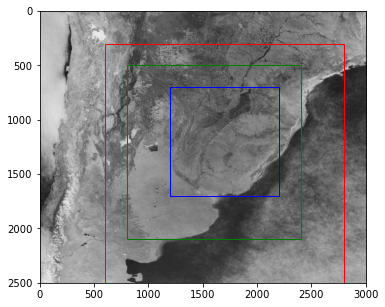

In [2]:
bkg = cv.imread('misc/bkg.png')

fig, ax = plt.subplots()

rect1 = patches.Rectangle((1200, 700), 1000, 1000, linewidth=1, edgecolor='b', facecolor='none') # xy, w, h
ax.add_patch(rect1)
rect2 = patches.Rectangle((800, 500), 1600, 1600, linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(rect2)
rect2 = patches.Rectangle((600, 300), 2200, 2200, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect2)

ax.imshow(bkg)


# 3. Como cargamos las imagenes a memoria

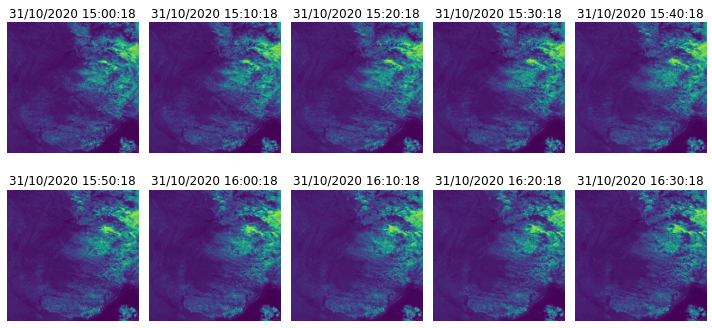

In [3]:
dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_305', 
                                           window = 10,
                                           transform = preprocessing.CropImage(3))

dataset_sw[0].keys()

dl_sw = DataLoader(dataset_sw, batch_size=1, collate_fn=data.collate_fn_sw)

for idx, samples in enumerate(dl_sw):
    if idx == 90:
        visualization.show_sample_dict(samples , 2)
        break

In [4]:
start = time.time()
for samples in dl_sw:
    pass
end = time.time()

print('Going through the images of one day with a sliding window of 10 images takes: ', end - start, ' seconds.')

Going through the images of one day with a sliding window of 10 images takes:  16.49802255630493  seconds.


# 4. Persistencia, persistencia borrosa, cmv

In [4]:
def get_data():
    predict_horizon = 10
    dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_305', 
                                            window = predict_horizon+2,
                                            transform = preprocessing.CropImage(3))
    dl_sw = DataLoader(dataset_sw, batch_size=1, collate_fn=data.collate_fn_sw)
    return dl_sw


def main_test(model_instance,dl_sw):
    predict_horizon_full = dl_sw.dataset.window-2
    error_list =[]
    error_list_day = []

    per_predict_time= []
    eval_time = []
    cmv_predict_time = []
    
    for idx, samples in enumerate(dl_sw):

        predict_horizon = samples['images'].shape[0] - 2
        if predict_horizon == 0:
            break

        if idx%50 == 0:
           print(idx)
        
        #predict depending on model
        if (isinstance(model_instance, model.Persistence)):
            start = time.time()
            predictions, prediction_ts = model_instance.predict(
                                    samples['images'][1], 
                                    samples['time_stamps'][1], 
                                    predict_horizon)
            end = time.time()
            per_predict_time.append(end-start)
            dynamic_window = False
        elif (isinstance(model_instance, model.Cmv)):
            start = time.time()
            predictions , cmv_ts = model_instance.predict(
                                    imgi=samples['images'][0, :, :], 
                                    imgf=samples['images'][1, :, :],
                                    imgf_ts = samples['time_stamps'][1], 
                                    period=10*60, delta_t=10*60, 
                                    predict_horizon=predict_horizon) 
            end = time.time()
            cmv_predict_time.append(end-start)
            dynamic_window = True

        #evaluate
        start = time.time()
        predict_errors = evaluate.evaluate_image(
                                                predictions = predictions, 
                                                gt = samples['images'][1:], 
                                                gt_ts = samples['time_stamps'][1:],
                                                metric='RMSE', dynamic_window=dynamic_window,
                                                evaluate_day_pixels = False)
        for _ in range(predict_horizon_full+1 - len(predict_errors)):
            #adds 0 in errors for predictions outside the day
            predict_errors.append(0)
        error_list.append(predict_errors)
        end = time.time()
        eval_time.append(end-start)
        predict_errors_day = evaluate.evaluate_image(
                                                predictions = predictions, 
                                                gt = samples['images'][1:], 
                                                gt_ts = samples['time_stamps'][1:],
                                                metric='RMSE', dynamic_window=dynamic_window,
                                                evaluate_day_pixels = True)
        for _ in range(predict_horizon_full+1 - len(predict_errors_day)):
            #adds 0 in errors for predictions outside the day
            predict_errors_day.append(0)
        error_list_day.append(predict_errors_day)
    print('persistence predict time: ', np.sum(per_predict_time))
    print('cmv predict time: ', np.sum(cmv_predict_time))
    print('evaluation time: ', np.sum(eval_time))
    return error_list , error_list_day


cmv = model.Cmv2()
blurredCMV = model.Cmv2(kernel_size=(21,21))
persistence = model.Persistence()

print('Predicting CMV')
dl_sw = get_data()
error_list_cmv, error_list_cmv_day = main_test(cmv,dl_sw)
print('Predicting Persistence')
dl_sw = get_data()
error_list_p,error_list_p_day = main_test(persistence,dl_sw)
print('Predicting Blurred CMV') 
dl_sw = get_data()
error_list_bp,error_list_bp_day = main_test(blurredCMV,dl_sw)

error_array_cmv = np.vstack(error_list_cmv)
error_array_p = np.vstack(error_list_p)
error_array_bp = np.vstack(error_list_bp)

error_array_cmv_day = np.vstack(error_list_cmv_day)
error_array_p_day = np.vstack(error_list_p_day)
error_array_bp_day = np.vstack(error_list_bp_day)

print('CMV predicted ', error_array_cmv.shape[1],  'images for' , error_array_cmv.shape[0], 'images')
print('Persistence predicted ', error_array_p.shape[1], 'images for' , error_array_p.shape[0],'images')
print('Blurred Persistence predicted ', error_array_bp.shape[1], 'images for' , error_array_bp.shape[0], 'images')

Predicting CMV
0
50
100
persistence predict time:  0.0
cmv predict time:  69.98011517524719
evaluation time:  14.307593822479248
Predicting Persistence
0
50
100
persistence predict time:  5.169421911239624
cmv predict time:  0.0
evaluation time:  13.599443912506104
Predicting Blurred CMV
0
50
100
persistence predict time:  0.0
cmv predict time:  84.68493366241455
evaluation time:  13.956790447235107
CMV predicted  11 images for 142 images
Persistence predicted  11 images for 142 images
Blurred Persistence predicted  11 images for 142 images


# 5. Guardo matriz de error del dia en un .csv

In [25]:
df_dataset = pd.read_csv("reports/dataset_2020.csv")
imgs_list_day1 = []

M = len(df_dataset.values[0][2])  
str_list = df_dataset.values[0][2][1:M-1].replace('\'',"" )
str_list = str_list.replace(" ", "")
imgs_list_day1 = str_list.split(",")

utils.save_errorarray_as_csv(error_array_cmv, time_stamp=imgs_list_day1 ,filename =  "reports/cmv_error")

# 6. Graficas de errores

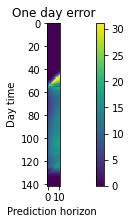

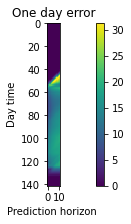

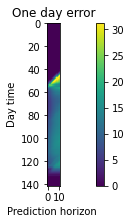

In [5]:
visualization.matrix_graph(error_array_cmv)
visualization.matrix_graph(error_array_p)
visualization.matrix_graph(error_array_bp)

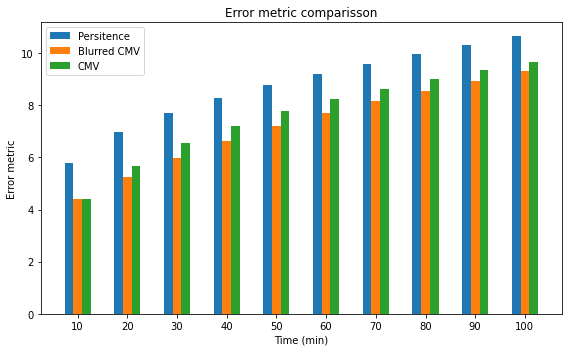

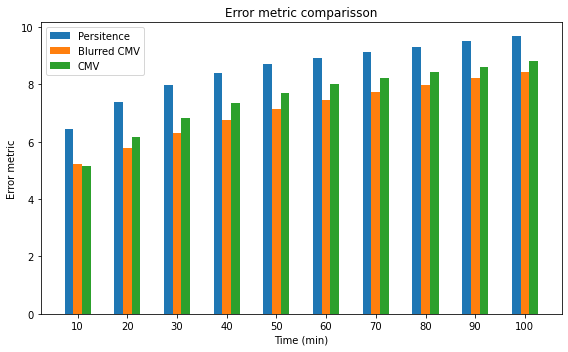

In [6]:
mean_error_cmv = np.mean(error_array_cmv,axis=0)
mean_error_p = np.mean(error_array_p,axis=0)
mean_error_bp = np.mean(error_array_bp,axis=0)

visualization.barchart_compare3(mean_error_p[1:], 'Persitence',
                 mean_error_bp[1:], 'Blurred CMV',
                 mean_error_cmv[1:], 'CMV')

mean_error_cmv_day = np.mean(error_array_cmv_day,axis=0)
mean_error_p_day = np.mean(error_array_p_day,axis=0)
mean_error_bp_day = np.mean(error_array_bp_day,axis=0)

visualization.barchart_compare3(mean_error_p_day[1:], 'Persitence',
                 mean_error_bp_day[1:], 'Blurred CMV',
                 mean_error_cmv_day[1:], 'CMV')

# 7. Visualizacion de las imagenes: ventana que saca nans, ventana sin nans


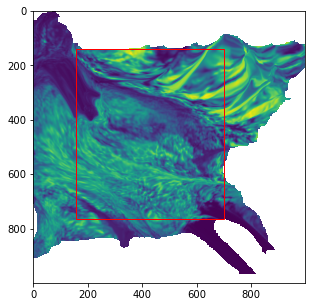

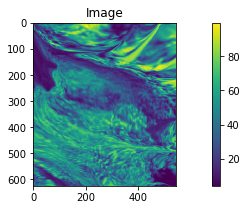

In [30]:
cmv2 = model.Cmv2()

predict_horizon = 30
dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_1',
                                           window = 2,
                                           transform = preprocessing.CropImage(3))

samples = dataset_sw[100]

predictions, cmv_ts = cmv2.predict(
                        imgi=samples['images'][0], 
                        imgf=samples['images'][1], 
                        imgf_ts = samples['time_stamps'][1], 
                        period=10*60, delta_t=10*60, 
                        predict_horizon=predict_horizon) 


image = predictions[-1]
xmin, xmax, ymin, ymax = utils.find_inner_image(image)
fig, ax = plt.subplots()

rect = patches.Rectangle((ymin, xmin), len(image)-(ymin+ymax), len(image)-(xmin+xmax), linewidth=1, edgecolor='r', facecolor='none')

plt.imshow(image)
ax.add_patch(rect)
plt.show()

visualization.show_image_w_colorbar(image [xmin:len(image)-xmax, ymin:len(image)-ymax] )

0.07507014274597168


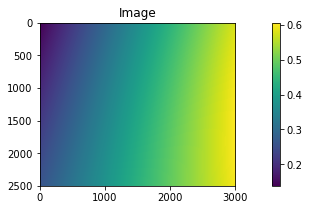

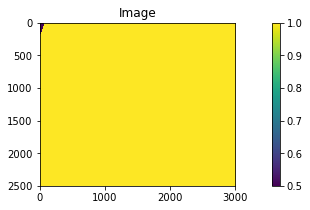

In [31]:
start = time.time()
cosangs, cosangs_thresh = utils.get_cosangs_mask(meta_path='data/meta',
                    img_name='ART_2020020_111017.FR'
    )
end = time.time()
print(end - start)

visualization.show_image_w_colorbar (cosangs)
visualization.show_image_w_colorbar (cosangs_thresh)

# 8. Trainning with train.py and tensorboard

In [ ]:
#TRAINNING WITH TRAIN.PY

torch.manual_seed(50)
criterion = nn.L1Loss()

epochs = 5
batch_size = 20
num_val_samples = 10
eval_every = 50

train_loader = DataLoader(train_mvd, batch_size=batch_size, shuffle=False, num_workers=2,pin_memory = True)
val_loader = DataLoader(val_mvd, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

learning_rates = [1e-3]
weight_decay = [1e-3]
grid_search = [ (lr, wd) for lr in learning_rates for wd in weight_decay ]

for lr, wd in grid_search:
  model = UNet(n_channels=3,n_classes=1,bilinear=True).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr ,betas = (0.9,0.999),eps =1e-08, weight_decay=wd ,amsgrad=False)
  print('lr =', lr, 'weight_decay =', wd)

  comment = f' batch_size = {batch_size} lr = {lr} weight_decay = {wd}'
  writer = SummaryWriter(comment=comment)

  TRAIN_LOSS_GLOBAL, VAL_LOSS_GLOBAL = train_model(model = model,
                                                  criterion= criterion,
                                                  optimizer=optimizer,
                                                  device=device,
                                                  train_loader= train_loader,
                                                  epochs=epochs,
                                                  val_loader = val_loader,
                                                  num_val_samples=num_val_samples,
                                                  checkpoint_every=None,
                                                  verbose = True,
                                                  eval_every = eval_every,
                                                  writer=writer)
  
  writer.add_hparams(
                    {"lr": lr, "bsize": batch_size, "weight_decay":wd},
                    {
                        "loss train": TRAIN_LOSS_GLOBAL[-1],
                        "loss validation": VAL_LOSS_GLOBAL[-1] ,
                    },)
                            
writer.close()